<a href="https://colab.research.google.com/github/achanhon/coursdeeplearningcolab/blob/master/finetuning_in_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning

L'objectif de ce TP est de montrer le concept du "finetuning" très souvent
utilisé pour traiter une tache spécifique à l'aide de réseaux de neurones génériques.

Le point de départ de ce concept est qu'il existe beaucoup de modèles disponibles sur internet pour des taches génériques.
Par exemple, si vous regarder la page https://pytorch.org/vision/main/models.html vous pouvez voir qu'il existe un grand nombre de modèle de classification "Imagenet", mais aussi des modèles de segmentation ou de détection "Ms Coco" (et il ne s'agit que des modèles pytorch, vous pourrez en trouver BEAUCOUP d'autres sur internet).

Cela signifique que si je veux segmenter des images de Ms Coco (ou très similaire), je n'ai pas forcément besoin d'apprendre un modèle moi-même: je peux juste repartir d'un modèle pytorch.

Testons ça avec 9 images coco.

<ipython-input-3-dbb48f1b1e36>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")


torch.Size([9, 3, 520, 520])


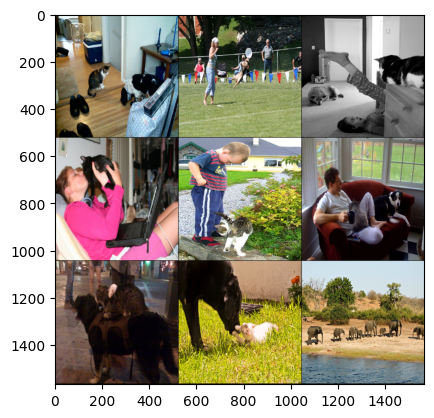

In [3]:
import os
import torch
import torchvision
import matplotlib.pyplot as plt

if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/663e829090246ad9f989b16d3a6e3a90YoJmz2/coco_sample.pth")

img = torch.load("coco_sample.pth")
print(img.shape)

visu = torchvision.utils.make_grid(img,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

les 9 images étant chargées, on peut leur appliquer un modèle deeplab pré-appris comme
torchvision.models.segmentation.DeepLabV3_ResNet50_Weights

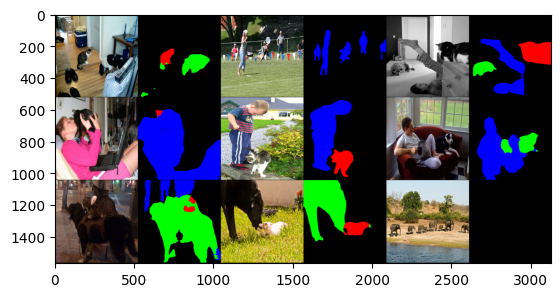

In [7]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

Le résultat est loin d'être parfait mais on voit que le réseau est "fonctionnel" (il s'agit d'un backbone resnet - au fait beaucoup mieux aujourd'hui mais il faut aller chercher les modèles ailleurs...).

On peut en tester un autre plus rapide (et moins bon) comme torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights:

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 126MB/s]


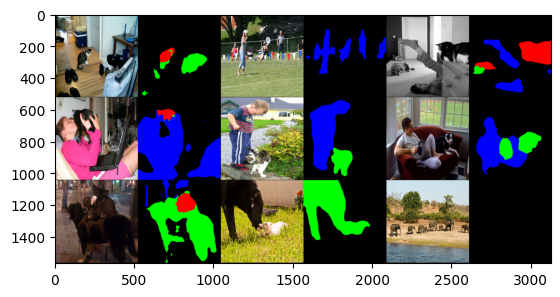

In [8]:
W = torchvision.models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()

normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

with torch.no_grad():
  x = normalize(img)
  z = net(x)["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img,pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

Maintenant, imaginons qu'on ne veut pas faire des images de chats et de chiens, mais des images satellite dans lesquelles on veut trouver les batiments. Les modèles qu'on vient de tester ne marcheront pas "directement" (ils n'ont pas été appris pour ça) mais cela ne veut pas dire qu'il n'est pas pertinent de repartir de ces modèles en les adaptant juste légèrement !

Commençons par considérer des données à traiter.

In [36]:
if not os.path.isfile("potsdam.zip"):
  os.system("wget https://httpmail.onera.fr/21/480b1c16661bcfca03f0ec2622865d28dKeYOW/potsdam.zip")
  os.system("unzip  potsdam.zip")
print(os.listdir("."))
print(os.listdir("./potsdam/train"))
print(os.listdir("./potsdam/test"))

['.config', 'potsdam.zip', 'coco_sample.pth', 'potsdam', 'sample_data']
['9_x.png', '1_y.png', '4_x.png', '4_y.png', '8_x.png', '12_y.png', '0_x.png', '13_x.png', '7_x.png', '12_x.png', '1_x.png', '11_y.png', '2_y.png', '2_x.png', '3_x.png', '3_y.png', '9_y.png', '8_y.png', '11_x.png', '6_x.png', '5_y.png', '5_x.png', '0_y.png', '10_x.png', '6_y.png', '13_y.png', '7_y.png', '10_y.png']
['9_x.png', '1_y.png', '4_x.png', '4_y.png', '8_x.png', '0_x.png', '7_x.png', '1_x.png', '2_y.png', '2_x.png', '3_x.png', '3_y.png', '9_y.png', '8_y.png', '6_x.png', '5_y.png', '5_x.png', '0_y.png', '6_y.png', '7_y.png']


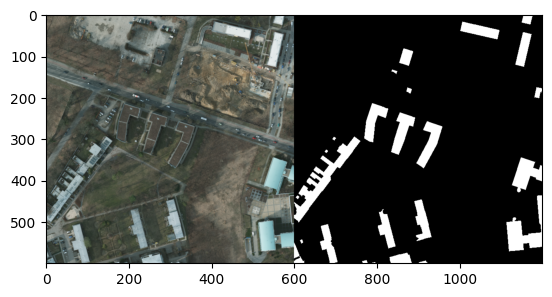

In [28]:
img1 = torchvision.io.read_image("potsdam/train/1_x.png")/255
lab1 = torchvision.io.read_image("potsdam/train/1_y.png")/255
visu = torch.cat([lab1]*3,dim=0)
visu = torch.cat([img1,visu],dim=-1)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

ok maintenant on prend notre réseau, on lui coupe la tête et on la replace par une nouvelle adaptée à la classification fond/batiment

In [32]:
# net = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(weights=W).eval()
print(net.classifier[4])
net.classifier[4] = torch.nn.Conv2d(256,2,kernel_size=1)

Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))


et on fait quelle iteration de descente de gradient

In [33]:
ce = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.0001)

for i in range(10):
  losses = []
  for j in range(10):
    alea = torch.rand(2)*14
    a,b = int(alea[0]),int(alea[1])
    X = torch.zeros(2,3,600,600)
    Y = torch.zeros(2,600,600)
    X[0] = torchvision.io.read_image("potsdam/train/"+str(a)+"_x.png")/255
    X[1] = torchvision.io.read_image("potsdam/train/"+str(b)+"_x.png")/255
    Y[0] = torchvision.io.read_image("potsdam/train/"+str(a)+"_y.png")[0]/255
    Y[1] = torchvision.io.read_image("potsdam/train/"+str(b)+"_y.png")[0]/255

    Z = net(normalize(X))["out"]
    loss = ce(Z,Y.long())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      losses.append(loss)

  print(sum(losses)/30)

KeyboardInterrupt: 

testons notre nouveau réseau sur la base de test pour voir s'il est déjà un peu adapté à notre problème (en seulement 100 itération, ce serait impossible d'obtenir la même chose sans partir d'un modèle pré appris et avec si peu de données) !

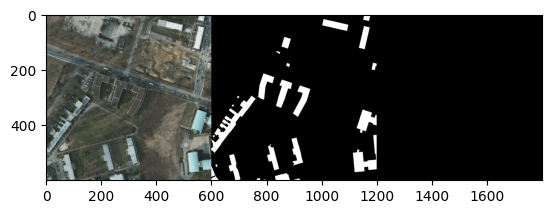

In [40]:
alea = torch.rand(1)*10
a=int(alea[0])
X = torch.zeros(1,3,600,600)
Y = torch.zeros(1,600,600)
X[0] = torchvision.io.read_image("potsdam/train/"+str(a)+"_x.png")/255
Y[0] = torchvision.io.read_image("potsdam/train/"+str(a)+"_y.png")[0]/255

with torch.no_grad():
  Z = net(normalize(X))["out"] # on prédit des cartes de score de confiance
  _,Z = Z.max(1) # on prend le meilleur score

visuZ = torch.stack([Z]*3,dim=1)
visuY = torch.stack([Y]*3,dim=1)
visu = torch.cat([X,visuY,visuZ],dim=-1)
visu = torch.transpose(torch.transpose(visu[0], 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()